In [1]:
import pandas as pd
from langdetect import detect
from collections import Counter
import re
import unicodedata
from contractions import fix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import spacy


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Loading the Datasets
article_outcome_1 = pd.read_csv("article_output.csv") #Article DataSet from Web scraping
article_outcome_2 = pd.read_csv("article_output_2.csv") #PDFs from Government Agencies

In [3]:
# Exploring the data for the dataset from webscraping
print(article_outcome_1.shape)
article_outcome_1.info()
article_outcome_1.head()

(44, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44 non-null     object
 1   content  44 non-null     object
 2   link     44 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


,title,content,link
0,Philippine budget process: Everything you need...,Budget preparation The Philippine Constitution...,https://www.rappler.com/newsbreak/explainers/t...
1,2025 budget ‘blanks’: Billions involved in DA ...,"There were also increases, the most notable of...",https://www.rappler.com/newsbreak/data-documen...
2,Claims of blank items in 2025 budget bicam rep...,I have recently encountered a plethora of comm...,https://opinion.inquirer.net/180508/claims-of-...
3,Senate receives copy of General Appropriations...,"MANILA, Philippines — The Senate formally rece...",https://newsinfo.inquirer.net/1996770/senate-r...
4,Makabayan wants bicam to convene again to addr...,France Castro —House of Representatives/Facebo...,https://newsinfo.inquirer.net/2016000/makabaya...


In [4]:
# Exploring the data for the dataset from PDF files of Government Agencies
print(article_outcome_2.shape)
article_outcome_2.info()
article_outcome_2.head()

(28, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    28 non-null     object
 1   content  27 non-null     object
 2   link     28 non-null     object
dtypes: object(3)
memory usage: 804.0+ bytes


,title,content,link
0,Philippine budget process: Everything you need...,Budget preparation The Philippine Constitution...,https://www.rappler.com/newsbreak/explainers/t...
1,2021-Peoples-Proposed-Budget,Table of Contents About the Cover This cover d...,2021-Peoples-Proposed-Budget.pdf
2,2025-Budget Priorities Framework-Macroeconomi-...,"Real GDP Growth – Over the medium-term, the go...",2025-Budget Priorities Framework-Macroeconomi-...
3,2025-Budget-Priorities-Framework-Expenditures-...,BRIEFER ON THE 2025 BUDGET PRIORITIES FRAMEWOR...,2025-Budget-Priorities-Framework-Expenditures-...
4,2025-People_s-Enacted-revised-as-of-42225,2025 PEOPLE’S ENACTED B U D G E T AGENDA FOR P...,2025-People_s-Enacted-revised-as-of-42225.pdf


In [5]:
# merging both PDF data and all Webscraped Data
article_outcomes = pd.concat([article_outcome_1, article_outcome_2], ignore_index=True)
# exploring the merged data
print(article_outcomes.shape)
article_outcomes.info()
article_outcomes.head()

(72, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    72 non-null     object
 1   content  71 non-null     object
 2   link     72 non-null     object
dtypes: object(3)
memory usage: 1.8+ KB


,title,content,link
0,Philippine budget process: Everything you need...,Budget preparation The Philippine Constitution...,https://www.rappler.com/newsbreak/explainers/t...
1,2025 budget ‘blanks’: Billions involved in DA ...,"There were also increases, the most notable of...",https://www.rappler.com/newsbreak/data-documen...
2,Claims of blank items in 2025 budget bicam rep...,I have recently encountered a plethora of comm...,https://opinion.inquirer.net/180508/claims-of-...
3,Senate receives copy of General Appropriations...,"MANILA, Philippines — The Senate formally rece...",https://newsinfo.inquirer.net/1996770/senate-r...
4,Makabayan wants bicam to convene again to addr...,France Castro —House of Representatives/Facebo...,https://newsinfo.inquirer.net/2016000/makabaya...


In [6]:
# Determine the language used for each article to develop a standard way for cleaning the data
detected_language = article_outcomes["content"].astype(str).apply(detect)
detected_language

0     en
1     en
2     en
3     en
4     en
      ..
67    en
68    en
69    en
70    en
71    tl
Name: content, Length: 72, dtype: object

In [7]:
# Count how many of each unique value in the list
Counter(detected_language)

Counter({'en': 66, 'tl': 6})

In [8]:
contractions_filipino_ver = {
    "sakin": "sa akin",
    "sayo": "sa iyo",
    "sakanya": "sa kanya",
    "satin": "sa atin",
    "samin": "sa amin",
    "sainyo": "sa inyo",
    "sakanila": "sa kanila",
    "sa'to": "sa ito",
    "sa'yan": "sa iyan",
    "sa'yon": "sa iyon",
    "dito": "sa ito",
    "diyan": "sa iyan",
    "doon": "sa iyon",
    "ngakin": "ng akin",
    "ngiyo": "ng iyo",
    "ngkanya": "ng kanya",
    "ngamin": "ng amin",
    "ngatin": "ng atin",
    "nginyo": "ng inyo",
    "ngkanila": "ng kanila",
    "di'ko": "hindi ako",
    "di'mo": "hindi mo",
    "di'ya": "hindi siya",
    "di'la": "hindi nila",
    "wala'ko": "wala ako",
    "nasa'kin": "nasa akin",
    "ako'y": "ako ay",
    "ika'y": "ikaw ay",
    "siya'y": "siya ay",
    "tayo'y": "tayo ay",
    "kami'y": "kami ay",
    "sila'y": "sila ay"
}

In [11]:
def unicode_data(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text
def handle_tokens(text,lang):
    match lang:
        case "en":
            stop_words = set(stopwords.words('english'))
            tokens = word_tokenize(text)
            text = " ".join([word for word in tokens if word not in stop_words])
        case "tl":
            nlp = spacy.load("tl_core_news_sm")
            doc = nlp(text)
            text = " ".join([token.text for token in doc if not token.is_stop])
    return text
def handle_contractions(text,lang):
    match lang:
        case "en":
            text = fix(text)
        case "tl":
            for contraction, expansion in contractions_filipino_ver.items():
                text = text.replace(contraction, expansion)
    return text
def general_text_preparation(text, lang=None):
    if not isinstance(text, str):
        if pd.isna(text):
            return ""
        text = str(text)
    text = unicode_data(text)
    text = text.lower()
    if lang:
        text = handle_contractions(text, lang)
    if lang:
        text = handle_tokens(text, lang)
    text = re.sub(r"[^a-zA-Z0-9\sáéíóúñü]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [12]:
article_outcomes["content"] = article_outcomes.apply(
    lambda row: general_text_preparation(
        text=row["content"],
        lang=row.name
    ),
    axis=1
)

In [13]:
article_outcomes["content"].head()

0    budget preparation the philippine constitution...
1    there were also increases the most notable of ...
2    i have recently encountered a plethora of comm...
3    manila philippines the senate formally receive...
4    france castro house of representativesfacebook...
Name: content, dtype: object

In [14]:
text = article_outcomes["content"].fillna("").astype(str).tolist()

In [15]:
# Translate string data to numerical data for training the model
embedder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
embeddings = embedder.encode(text,normalize_embeddings=True)
print(embeddings.shape)

(72, 768)


In [16]:
# Train the Gaussian Mixture Model with the embeddings
gmm = GaussianMixture(
    n_components=5,
    covariance_type="full", 
    random_state=42,
    verbose=1
)
gmm.fit(embeddings)

Initialization 0
Initialization converged.


GaussianMixture(n_components=5, random_state=42, verbose=1)

In [17]:
log_likelihoods = gmm.score_samples(embeddings)  
article_outcomes["anomaly_score"] = -log_likelihoods

threshold = np.quantile(article_outcomes["anomaly_score"], 0.95)
article_outcomes["is_anomaly"] = (article_outcomes["anomaly_score"] > threshold).astype(int)

In [18]:
anomalies = article_outcomes.sort_values("anomaly_score", ascending=False).head(5)
print(anomalies[["content", "anomaly_score", "is_anomaly"]])

                                              content  anomaly_score  \
1   there were also increases the most notable of ...   -4498.487014   
16  budget secretary amenah pangandaman on monday ...   -4498.487201   
4   france castro house of representativesfacebook...   -4498.487213   
9   manila philippines opposition lawmaker sen ris...   -4498.487215   
25  dbm press release marking a significant step i...   -4498.487244   

    is_anomaly  
1            1  
16           1  
4            1  
9            1  
25           0  


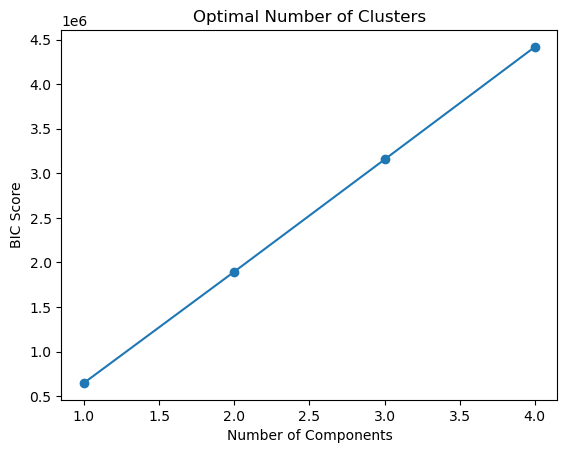

In [19]:
n_components_range = range(1, 5)
bic_values = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(embeddings)
    bic_values.append(gmm.bic(embeddings))

plt.plot(n_components_range, bic_values, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.title("Optimal Number of Clusters")
plt.show()

In [20]:
# optimized version
gmm_prime = GaussianMixture(
    n_components=1,
    covariance_type="full", 
    random_state=42,
    verbose=1
)
gmm_prime.fit(embeddings)

Initialization 0
Initialization converged.


GaussianMixture(random_state=42, verbose=1)

In [21]:
log_likelihoods_prime = gmm_prime.score_samples(embeddings)  
article_outcomes["anomaly_score_prime"] = -log_likelihoods_prime

threshold_prime = np.quantile(article_outcomes["anomaly_score_prime"], 0.95)
article_outcomes["is_anomaly"] = (article_outcomes["anomaly_score_prime"] > threshold_prime).astype(int)

In [22]:
anomalies = article_outcomes.sort_values("anomaly_score_prime", ascending=False).head(5)
print(anomalies[["content", "anomaly_score_prime", "is_anomaly"]])

                                              content  anomaly_score_prime  \
71                                                            -4294.823504   
46  real gdp growth over the mediumterm the govern...         -4294.827758   
31  a youtube video falsely claims that president ...         -4294.830554   
53  5 agency tier 1 proposals ongoing expenditures...         -4294.830880   
55  ii fiscal policy in relation to overall develo...         -4294.831123   

    is_anomaly  
71           1  
46           1  
31           1  
53           1  
55           0  


In [23]:
labels_prime = gmm_prime.predict(embeddings)

In [24]:
anomalies = (article_outcomes["anomaly_score_prime"] > threshold_prime).values
embeddings_reduced_pca = PCA(n_components=2)
embeddings_pca = embeddings_reduced_pca.fit_transform(embeddings)

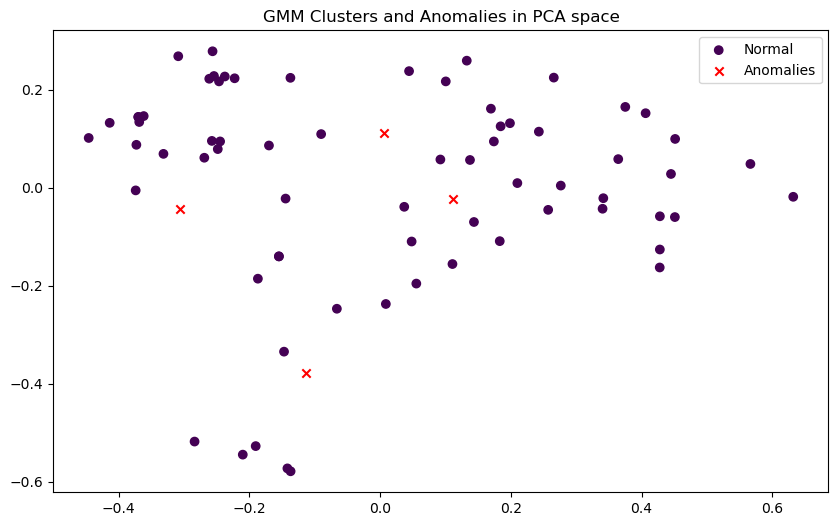

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca[~anomalies, 0], embeddings_pca[~anomalies, 1], c=labels_prime[~anomalies], cmap='viridis', label='Normal')
plt.scatter(embeddings_pca[anomalies, 0], embeddings_pca[anomalies, 1], c='red', marker='x', label='Anomalies')
plt.title("GMM Clusters and Anomalies in PCA space")
plt.legend()
plt.show()

In [28]:
new_data_pred = gmm.predict([embeddings[0]])[0]
same_label_indices = np.where(gmm.predict(embeddings) == new_data_pred)[0]
component_points = embeddings[same_label_indices]

mean = gmm.means_[new_data_pred]
cov = gmm.covariances_[new_data_pred]

try:
    inv_cov = np.linalg.inv(cov)
except np.linalg.LinAlgError:
    cov += np.eye(cov.shape[0]) * 1e-6
    inv_cov = np.linalg.inv(cov)

distances = [mahalanobis(x, mean, inv_cov) for x in component_points]
sorted_local_indices = np.argsort(distances)

nearest_articles_ind = same_label_indices[sorted_local_indices[:5]]

row_ind = []
for i, idx in enumerate(nearest_articles_ind):
    print(f"Rank {i+1}: Index {idx}, Distance {distances[sorted_local_indices[i]]}")
    row_ind.append(idx)

Rank 1: Index 0, Distance 3.1622299445200577
Rank 2: Index 44, Distance 3.1622299445200577
Rank 3: Index 3, Distance 4.58220225596062
Rank 4: Index 7, Distance 4.582216701050258
Rank 5: Index 34, Distance 4.582221559021075


In [29]:
deemed_references = article_outcomes.iloc[row_ind]
deemed_references

,title,content,link,anomaly_score,is_anomaly,anomaly_score_prime
0,Philippine budget process: Everything you need...,budget preparation the philippine constitution...,https://www.rappler.com/newsbreak/explainers/t...,-4503.736560,0,-4312.824180
44,Philippine budget process: Everything you need...,budget preparation the philippine constitution...,https://www.rappler.com/newsbreak/explainers/t...,-4503.736560,0,-4312.824180
3,Senate receives copy of General Appropriations...,manila philippines the senate formally receive...,https://newsinfo.inquirer.net/1996770/senate-r...,-4498.487940,0,-4294.850611
7,Overhauling the 2025 GAA,if it is any indication that the 2025 general ...,https://www.philstar.com/opinion/2025/01/15/24...,-4498.487906,0,-4294.847511
34,"Marcos signs 2025 budget, vetoes items inconsi...",ten days after the original date of the signin...,https://tribune.net.ph/2024/12/30/marcos-signs...,-4498.487877,0,-4294.851446


In [31]:
synthetic_data = [
    "Senate Finance Committee chairperson Sen. Grace Poe and House Appropriations Committee chairperson Rep. Elizaldy 'Zaldy' Co show copies of the adopted and approved Bicameral Conference Committee Report on the disagreeing provisions of the proposed 2025 national budget following the meeting of the bicameral panel at Manila Hotel in Manila Tuesday (Dec. 11, 2024). Also in photo are House members led by Speaker Ferdinand Martin G. Romualdez and senators led by Senate President Chiz Escudero.",
    "Ipinapakita nina Sen. Grace Poe, chairperson ng Senate Finance Committee, at Rep. Elizaldy 'Zaldy' Co, chairperson ng House Appropriations Committee, ang mga kopya ng inampon at naaprubahang Ulat ng Bicameral Conference Committee sa mga nagtatalunang probisyon ng iminungkahing pambansang badyet para sa 2025 kasunod ng pulong ng bicameral panel sa Manila Hotel sa Maynila noong Martes (Disyembre 11, 2024). Kasama rin sa larawan ang mga miyembro ng Kapulungan na pinangunahan ni Speaker Ferdinand Martin G. Romualdez at mga senador na pinangunahan ni Senate President Chiz Escudero.",
    "Ipinapakita ninda Sen. Grace Poe, tagapangulo kan Senate Finance Committee, asin Rep. Elizaldy 'Zaldy' Co, tagapangulo kan House Appropriations Committee, an mga kopya kan inampon asin naaprubahang Ulat kan Bicameral Conference Committee sa mga nagtatalunang probisyon kan iminungkahing pambansang badyet para sa 2025 kasunod kan pulong kan bicameral panel sa Manila Hotel sa Maynila kan Martes (Disyembre 11, 2024). Kasama man sa larawan an mga miyembro kan Kapulungan na pinangunahan ni Speaker Ferdinand Martin G. Romualdez asin mga senador na pinangunahan ni Senate President Chiz Escudero.",
    "Gipakita nila Sen. Grace Poe, ang chairperson sa Senate Finance Committee, ug Rep. Elizaldy 'Zaldy' Co, ang chairperson sa House Appropriations Committee, ang mga kopya sa giampon ug naaprubahan nga Ulat sa Bicameral Conference Committee sa mga nagkontra nga probisyon sa ginasugyot nga pambansang badyet para sa 2025 human sa miting sa bicameral panel sa Manila Hotel sa Maynila niadtong Martes (Disyembre 11, 2024). Apil usab sa litrato ang mga miyembro sa Kapulungan nga gipangulohan ni Speaker Ferdinand Martin G. Romualdez ug mga senador nga gipangulohan ni Senate President Chiz Escudero.",
    "Ginpahayag nila Sen. Grace Poe, tagapangulo sang Senate Finance Committee, kag Rep. Elizaldy 'Zaldy' Co, tagapangulo sang House Appropriations Committee, ang mga kopya sang gin-aprobahan nga Ulat sang Bicameral Conference Committee sa mga nagtatalunang probisyon sang ginmungkahi nga pambansang badyet para sa 2025 kasunod sang pulong sang bicameral panel sa Manila Hotel sa Maynila sang Martes (Disyembre 11, 2024). Kaupod man sa litrato ang mga miyembro sang Kapulungan nga ginpangunahan ni Speaker Ferdinand Martin G. Romualdez kag mga senador nga ginpangunahan ni Senate President Chiz Escudero.", 
    "Ipinapakita da Sen. Grace Poe, chairperson ti Senate Finance Committee, ken Rep. Elizaldy 'Zaldy' Co, chairperson ti House Appropriations Committee, dagiti kopya ti inampon ken naaprubahang Ulat ti Bicameral Conference Committee kadagiti nagtatalunang probisyon ti iminungkahing pambansang badyet para iti 2025 kasunod ti pulong ti bicameral panel idiay Manila Hotel iti Maynila idi Martes (Disyembre 11, 2024). Kaduana iti ladawan dagiti miyembro ti Kapulungan a pinangunahan ni Speaker Ferdinand Martin G. Romualdez ken dagiti senador a pinangunahan ni Senate President Chiz Escudero.",
    "Ipinapakita da Sen. Grace Poe, chairperson ti Senate Finance Committee, ken Rep. Elizaldy 'Zaldy' Co, chairperson ti House Appropriations Committee, dagiti kopya ti inampon ken naaprubahang Ulat ti Bicameral Conference Committee kadagiti nagtatalunang probisyon ti iminungkahing pambansang badyet para iti 2025 kasunod ti pulong ti bicameral panel idiay Manila Hotel iti Maynila idi Martes (Disyembre 11, 2024). Kaduana iti ladawan dagiti miyembro ti Kapulungan a pinangunahan ni Speaker Ferdinand Martin G. Romualdez ken dagiti senador a pinangunahan ni Senate President Chiz Escudero."
]
# English, Filipino, Bikol ,Cebuano, Hiligaynon, Illocano, Waray
# codes_oflang = [detect(data) for data in synthetic_data]
# synthetic_data = [general_text_preparation(data,codes_oflang[i]) for i,data in enumerate(synthetic_data)]